In [229]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


#### Load a test image

(356, 460)


(-0.5, 459.5, 355.5, -0.5)

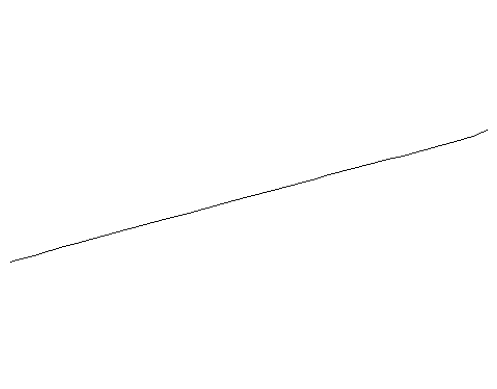

In [230]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img = cv2.imread("./slightly_tilted_line.png", cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.axis('off')

#### Apply Canny edge detcion to get an edge map of the image

(-0.5, 459.5, 355.5, -0.5)

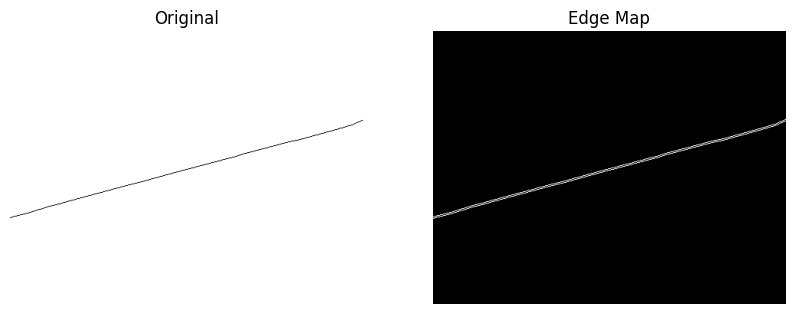

In [232]:
img_edge = cv2.Canny(img, threshold1=100, threshold2=200, apertureSize=3)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_edge, cmap='gray')
plt.title('Edge Map')
plt.axis('off')

In [351]:
print(np.argmax(img_edge[:,0]))
print(img_edge.shape[0] - 1 - np.argmax(img_edge[:,0]))

242
113


#### A basic version of Hough Transform using cartesian parameter representation, i.e. the parameters (a,b) represent the (slope, y-intercept) of the line. The hyperparameters are the number of bins and the thresholding to find the intersection/voting peaks and the number of peaks (i.e. number of lines to detect)

In [235]:
import os

In [313]:
def hough_cart(img, num_lines=20, a_bins=10000, b_bins=10000, non_max_suppression=False):

    # specify parameter space bounds, will get split into equal sized bins 
    amin = -500
    amax = 500
    bmin = -10000
    bmax = 10000

    # specify bin parameter values
    a_bin_edges = np.linspace(amin, amax, a_bins+1)
    a_bin_values = 0.5 * (a_bin_edges[0:-1] + a_bin_edges[1:])
    b_bin_edges = np.linspace(bmin, bmax, b_bins+1)
    b_bin_values = 0.5 * (b_bin_edges[0:-1] + b_bin_edges[1:])

    # create a grid of bins in parameter space
    bins = np.zeros(shape=(a_bins, b_bins))

    # iterate over each pixel position
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            # accumulate votes in parameter space bins if the pixel is an edge point
            if(img[y,x]>0):
                # note, the y-cordinate of the image point is flipped
                b_values = (img.shape[0]-1-y) - a_bin_values * x
                b_values_bins = np.digitize(b_values, b_bin_edges)-1

                # clip values that fall outside the bins and place them into the edge bins    
                b_values_bins[b_values_bins<0] = 0
                b_values_bins[b_values_bins>b_bins-1] = b_bins-1
                #print(b_values_bins)
                #print(b_values)
                
                for i in range(a_bins):
                    bins[i,b_values_bins[i]] += 1        


    # set the edge bins to zero to remove large values
    bins[0,:] = 0
    bins[-1,:] = 0
    bins[:,0] = 0
    bins[:,-1] = 0

    # perform thresholding
    thr = 0.2
    bins_thr = np.array(bins)
    bins_thr[bins_thr < thr*np.max(bins)] = 0

    # apply non-maximal suppression on the bins (i.s. zero out all values less than the max value inside patch of size 10)
    if non_max_suppression:
        w2 = 5 # window half-size
        for i in range(w2, bins_thr.shape[0]-w2):
            for j in range(w2, bins_thr.shape[1]-w2):
                patch = bins_thr[i-w2:i+w2, j-w2:j+w2]
                maxval = np.max(patch)
                patch[patch < maxval] = 0
                bins_thr[i-w2:i+w2, j-w2:j+w2] = patch
    

    # now find the bins with largest number of vote counts
    flat_indices = np.argpartition(bins_thr, -num_lines, axis=None)[-num_lines:]

    # Sort the indices based on the corresponding values
    sorted_indices = flat_indices[np.argsort(bins_thr.flat[flat_indices])]

    # Convert the sorted flat indices to row and column indices
    row_indices, col_indices = np.unravel_index(sorted_indices, bins_thr.shape)

    #print(row_indices)
    #print(col_indices)
    
    # peak parameter values
    peaks = []
    for i in range(len(row_indices)):
        peak = (a_bin_values[row_indices[i]], img.shape[0]-1-b_bin_values[col_indices[i]])
        peaks.append(peak)
        print(f"Peak {i}: {peak}, Votes: {bins[row_indices[i], col_indices[i]]}")

    return peaks


[5027 5027 5027 5027 5027 5026 5027 5026 5027 5026 5026 5026 5026 5026
 5027 5026 5026 5027 5026 5027]
[5558 5563 5564 5566 5565 5577 5553 5575 5557 5573 5576 5567 5574 5563
 5554 5565 5564 5555 5566 5556]
Peak 0: (0.27500000000000213, 243.29999999999995), Votes: 43.0
Peak 1: (0.27500000000000213, 242.29999999999995), Votes: 43.0
Peak 2: (0.27500000000000213, 242.10000000000002), Votes: 44.0
Peak 3: (0.27500000000000213, 241.69999999999993), Votes: 45.0
Peak 4: (0.27500000000000213, 241.89999999999998), Votes: 46.0
Peak 5: (0.26500000000000057, 239.4999999999999), Votes: 48.0
Peak 6: (0.27500000000000213, 244.29999999999995), Votes: 49.0
Peak 7: (0.26500000000000057, 239.89999999999998), Votes: 50.0
Peak 8: (0.27500000000000213, 243.4999999999999), Votes: 50.0
Peak 9: (0.26500000000000057, 240.29999999999995), Votes: 53.0
Peak 10: (0.26500000000000057, 239.69999999999993), Votes: 54.0
Peak 11: (0.26500000000000057, 241.4999999999999), Votes: 54.0
Peak 12: (0.26500000000000057, 240.1000

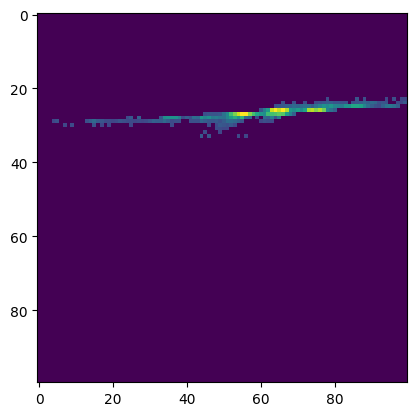

In [241]:
lines = hough_cart(img_edge)

In [346]:
np.sin(np.arctan(1/0.275))*242

233.33770505851726

#### Visualizing the lines

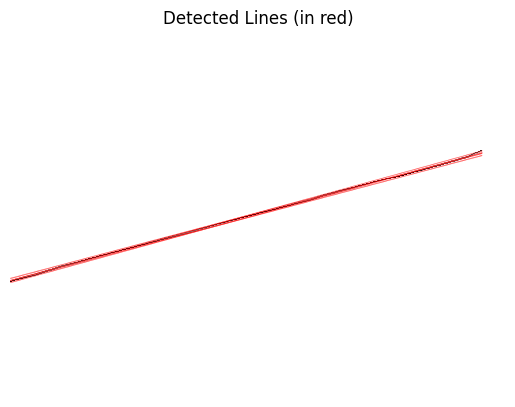

In [265]:
# first convert the gray scale image to color
color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 

plt.imshow(color_img) 
plt.title("Detected Lines (in red)")
plt.axis('off')

# display the lines overlayed on the image
for line in lines:
    a, b = line
    a = -a
    x = np.linspace(0,color_img.shape[1],10)
    y = a*x + b

    # draw the line in red
    plt.plot(x,y, color='red', linestyle='--', linewidth=0.15)



plt.show()

#### Now, lets try a different image

(406, 611)


(-0.5, 610.5, 405.5, -0.5)

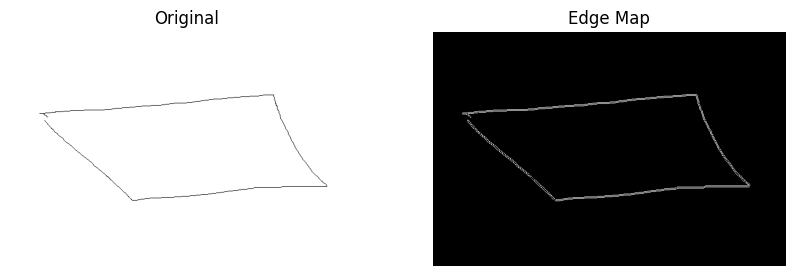

In [268]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img2 = cv2.imread("./paralellogram.png", cv2.IMREAD_GRAYSCALE)
print(img2.shape)

img_edge2 = cv2.Canny(img2, threshold1=100, threshold2=200, apertureSize=3)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img2, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_edge2, cmap='gray')
plt.title('Edge Map')
plt.axis('off')

In [314]:
lines2 = hough_cart(img_edge2, num_lines=35)

Peak 0: (-1.349999999999966, -466.0), Votes: 55.0
Peak 1: (-2.049999999999983, -812.0), Votes: 56.0
Peak 2: (0.1500000000000341, 174.0), Votes: 0.0
Peak 3: (-0.7499999999999716, 122.0), Votes: 0.0
Peak 4: (0.1500000000000341, 164.0), Votes: 0.0
Peak 5: (-1.9499999999999886, -764.0), Votes: 58.0
Peak 6: (0.1500000000000341, 152.0), Votes: 0.0
Peak 7: (0.1500000000000341, 330.0), Votes: 0.0
Peak 8: (-0.04999999999998295, 130.0), Votes: 0.0
Peak 9: (-0.9499999999999886, 92.0), Votes: 0.0
Peak 10: (0.1500000000000341, 326.0), Votes: 0.0
Peak 11: (0.1500000000000341, 166.0), Votes: 0.0
Peak 12: (0.05000000000001137, 298.0), Votes: 0.0
Peak 13: (0.05000000000001137, 136.0), Votes: 0.0
Peak 14: (-0.04999999999998295, 242.0), Votes: 72.0
Peak 15: (0.1500000000000341, 162.0), Votes: 0.0
Peak 16: (0.1500000000000341, 172.0), Votes: 0.0
Peak 17: (0.05000000000001137, 132.0), Votes: 0.0
Peak 18: (0.05000000000001137, 138.0), Votes: 0.0
Peak 19: (0.05000000000001137, 296.0), Votes: 0.0
Peak 20: (-0

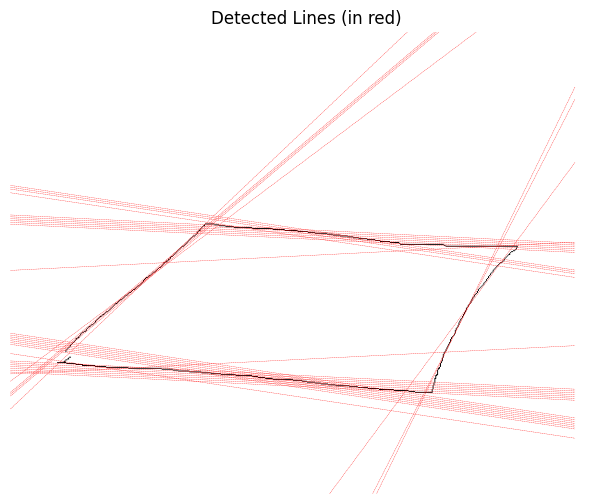

In [315]:
# first convert the gray scale image to color
color_img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB) 

plt.figure(figsize=(8,6))
plt.imshow(color_img2) 
plt.title("Detected Lines (in red)")
plt.axis('off')

# display the lines overlayed on the image
for line in lines2:
    a, b = line
    a = -a
    x = np.linspace(0,color_img2.shape[1],10)
    y = a*x + b

    # draw the line in red
    plt.plot(x,y, color='red', linestyle='--', linewidth=0.25)

plt.ylim(0,500)

plt.show()

#### Now let's implement a more efficient Hough Transform that uses polar coordinate parametrization

In [390]:
def hough_polar(img, num_lines=20, r_bins=5000, theta_bins=5000, non_max_suppression=False, suppression_window_halfsize=2):

    # specify parameter space bounds, will get split into equal sized bins 
    rmin = 0
    rmax = 2000
    thetamin = 0
    thetamax = 2.0*np.pi

    # specify bin parameter values
    r_bin_edges = np.linspace(rmin, rmax, r_bins+1)
    r_bin_values = 0.5 * (r_bin_edges[0:-1] + r_bin_edges[1:])
    theta_bin_edges = np.linspace(thetamin, thetamax, theta_bins+1)
    theta_bin_values = 0.5 * (theta_bin_edges[0:-1] + theta_bin_edges[1:])

    # create a grid of bins in parameter space
    bins = np.zeros(shape=(theta_bins, r_bins))

    # iterate over each pixel position
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            # accumulate votes in parameter space bins if the pixel is an edge point
            if(img[y,x]>0):
                # note: the y-cordinate of the image point is flipped
                r_values = (img.shape[0]-1-y) * np.sin(theta_bin_values) -  x * np.cos(theta_bin_values)
                r_values_bins = np.digitize(r_values, r_bin_edges)-1

                # clip values that fall outside the bins and place them into the edge bins    
                r_values_bins[r_values_bins<0] = 0
                r_values_bins[r_values_bins>r_bins-1] = r_bins-1
                #print(b_values_bins)
                #print(b_values)
                
                for i in range(theta_bins):
                    bins[i,r_values_bins[i]] += 1        


    # set the edge bins to zero to remove large values
    bins[0,:] = 0
    bins[-1,:] = 0
    bins[:,0] = 0
    bins[:,-1] = 0

    # perform thresholding
    thr = 0.2
    bins_thr = np.array(bins)
    bins_thr[bins_thr < thr*np.max(bins)] = 0

    # apply non-maximal suppression on the bins (i.s. zero out all values less than the max value inside patch of size 10)
    if non_max_suppression:
        w2 = suppression_window_halfsize # window half-size
        for i in range(w2, bins_thr.shape[0]-w2):
            for j in range(w2, bins_thr.shape[1]-w2):
                patch = bins_thr[i-w2:i+w2, j-w2:j+w2]
                maxval = np.max(patch)
                patch[patch < maxval] = 0
                bins_thr[i-w2:i+w2, j-w2:j+w2] = patch
    
   
    plt.imshow(bins)


    # now find the bins with largest number of vote counts
    flat_indices = np.argpartition(bins_thr, -num_lines, axis=None)[-num_lines:]

    # Sort the indices based on the corresponding values
    sorted_indices = flat_indices[np.argsort(bins_thr.flat[flat_indices])]

    # Convert the sorted flat indices to row and column indices
    row_indices, col_indices = np.unravel_index(sorted_indices, bins_thr.shape)

    #print(row_indices)
    #print(col_indices)
    
    # peak parameter values
    peaks = []
    for i in range(len(row_indices)):
        peak = (theta_bin_values[row_indices[i]], r_bin_values[col_indices[i]])
        votes = bins[row_indices[i], col_indices[i]]
        if votes > 0:
            peaks.append(peak)
            print(f"Peak {i}: {peak}, Votes: {bins[row_indices[i], col_indices[i]]}")

    return peaks


Peak 0: (1.3050175883012, 107.80000000000001), Votes: 125.0
Peak 1: (1.3050175883012, 107.4), Votes: 127.0
Peak 2: (1.3113007736083797, 109.0), Votes: 127.0
Peak 3: (1.3113007736083797, 109.4), Votes: 127.0
Peak 4: (1.3100441365469437, 111.0), Votes: 130.0
Peak 5: (1.307530862424072, 107.80000000000001), Votes: 130.0
Peak 6: (1.3100441365469437, 108.60000000000001), Votes: 132.0
Peak 7: (1.3037609512397643, 107.4), Votes: 135.0
Peak 8: (1.3050175883012, 109.4), Votes: 136.0
Peak 9: (1.3087874994855078, 108.2), Votes: 139.0
Peak 10: (1.3100441365469437, 110.60000000000001), Votes: 139.0
Peak 11: (1.307530862424072, 109.80000000000001), Votes: 144.0
Peak 12: (1.3087874994855078, 110.60000000000001), Votes: 147.0
Peak 13: (1.307530862424072, 110.2), Votes: 149.0
Peak 14: (1.3062742253626358, 109.80000000000001), Votes: 149.0
Peak 15: (1.3062742253626358, 107.80000000000001), Votes: 149.0
Peak 16: (1.3100441365469437, 109.0), Votes: 149.0
Peak 17: (1.3087874994855078, 110.2), Votes: 151.0


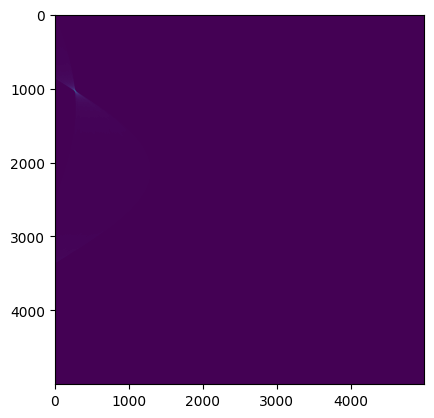

In [391]:
lines_polar = hough_polar(img_edge, num_lines=20, non_max_suppression=False)

r :107.80000000000001, theta: 1.3050175883012
a :-0.27221882274028447, b: 244.2772175301287
r :107.4, theta: 1.3050175883012
a :-0.27221882274028447, b: 244.6917733092377
r :109.0, theta: 1.3113007736083797
a :-0.26548146892132096, b: 243.22421467683353
r :109.4, theta: 1.3113007736083797
a :-0.26548146892132096, b: 242.81035858390447
r :111.0, theta: 1.3100441365469437
a :-0.26682712391596813, b: 241.11651679244926
r :107.80000000000001, theta: 1.307530862424072
a :-0.2695211472083916, b: 244.35324913839113
r :108.60000000000001, theta: 1.3100441365469437
a :-0.26682712391596813, b: 243.60048399693682
r :107.4, theta: 1.3037609512397643
a :-0.2735690430822371, b: 244.65359599668142
r :109.4, theta: 1.3050175883012
a :-0.27221882274028447, b: 242.61899441369277
r :108.2, theta: 1.3087874994855078
a :-0.2681736816230745, b: 243.9768281778142
r :110.60000000000001, theta: 1.3100441365469437
a :-0.26682712391596813, b: 241.53051132653053
r :109.80000000000001, theta: 1.307530862424072
a :

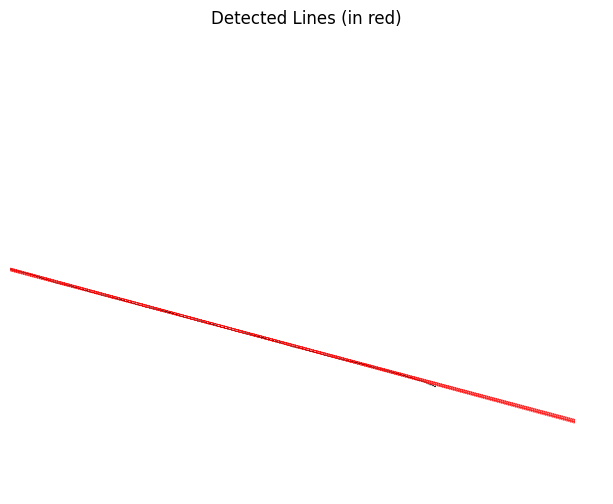

In [393]:
# first convert the gray scale image to color
color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 

plt.figure(figsize=(8,6))
plt.imshow(color_img) 
plt.title("Detected Lines (in red)")
plt.axis('off')

# display the lines overlayed on the image
for line in lines_polar:
    theta, r = line
    a = -1.0/np.tan(theta)
    b = color_img.shape[0] - (r / np.sin(theta))
    print(f"r :{r}, theta: {theta}")
    print(f"a :{a}, b: {b}")
    x = np.linspace(0,color_img2.shape[1],10)
    y = a*x + b

    # draw the line in red
    plt.plot(x,y, color='red', linestyle='--', linewidth=0.25)

plt.ylim(0,500)

plt.show()

#### Now let's try the polar Hough transform with the paralellogram

Peak 171: (2.3555661716616267, 485.8), Votes: 26.0
Peak 172: (2.3605927199073706, 487.0), Votes: 26.0
Peak 173: (2.3593360828459344, 486.6), Votes: 26.0
Peak 174: (2.3530528975387552, 485.0), Votes: 26.0
Peak 175: (1.6015839348000767, 152.60000000000002), Votes: 26.0
Peak 176: (2.7501502089525047, 531.8), Votes: 26.0
Peak 177: (2.351796260477319, 484.6), Votes: 26.0
Peak 178: (2.356822808723063, 485.8), Votes: 26.0
Peak 179: (1.581477741817102, 118.60000000000001), Votes: 27.0
Peak 180: (2.506362619033937, 518.6), Votes: 27.0
Peak 181: (2.3618493569688064, 227.0), Votes: 28.0
Peak 182: (2.8192652473314803, 525.8), Votes: 28.0
Peak 183: (2.3605927199073706, 227.0), Votes: 28.0
Peak 184: (2.6684687999591703, 533.8), Votes: 33.0
Peak 185: (1.5701680082641785, 293.8), Votes: 35.0
Peak 186: (1.5638848229569988, 291.0), Votes: 35.0
Peak 187: (1.5739379194484862, 295.4), Votes: 35.0
Peak 188: (1.5676547341413067, 292.6), Votes: 35.0
Peak 189: (1.5714246453256147, 294.20000000000005), Votes: 3

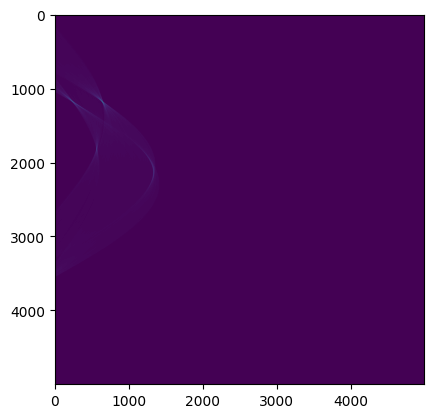

In [396]:
lines2_polar = hough_polar(img_edge2, num_lines=200, non_max_suppression=True, suppression_window_halfsize=20)

r :485.8, theta: 2.3555661716616267
a :0.9987441518459677, b: -280.5936846222688
r :487.0, theta: 2.3605927199073706
a :1.0088353764169833, b: -285.77125490322874
r :486.6, theta: 2.3593360828459344
a :1.0063030075253936, b: -284.32845331238934
r :485.0, theta: 2.3530528975387552
a :0.9937364715416147, b: -277.74889494189404
r :152.60000000000002, theta: 1.6015839348000767
a :0.030797339314683488, b: 253.32764842476274
r :531.8, theta: 2.7501502089525047
a :2.4228205332440877, b: -987.8902395006473
r :484.6, theta: 2.351796260477319
a :0.9912420037763113, b: -276.3334424427968
r :485.8, theta: 2.356822808723063
a :1.0012574272917751, b: -281.4570262596735
r :118.60000000000001, theta: 1.581477741817102
a :0.010681821264311286, b: 287.39323398557974
r :518.6, theta: 2.506362619033937
a :1.3565652734569398, b: -468.00169600176775
r :227.0, theta: 2.3618493569688064
a :1.0113741742324462, b: 83.142653715974
r :525.8, theta: 2.8192652473314803
a :2.994241446241925, b: -1253.8534014664303
r

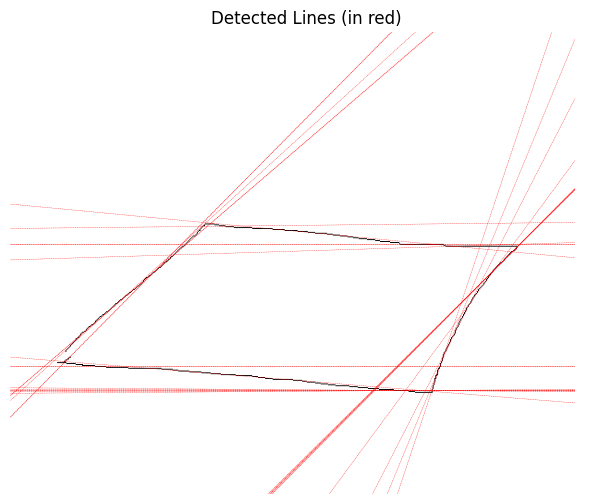

In [397]:
# first convert the gray scale image to color
color_img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB) 

plt.figure(figsize=(8,6))
plt.imshow(color_img2) 
plt.title("Detected Lines (in red)")
plt.axis('off')

# display the lines overlayed on the image
for line in lines2_polar:
    theta, r = line
    a = -1.0/np.tan(theta)
    b = color_img2.shape[0] - (r / np.sin(theta))
    print(f"r :{r}, theta: {theta}")
    print(f"a :{a}, b: {b}")
    x = np.linspace(0,color_img2.shape[1],10)
    y = a*x + b

    # draw the line in red
    plt.plot(x,y, color='red', linestyle='--', linewidth=0.25)

plt.ylim(0,500)

plt.show()

#### It works!! :)

(640, 640)


(-0.5, 639.5, 639.5, -0.5)

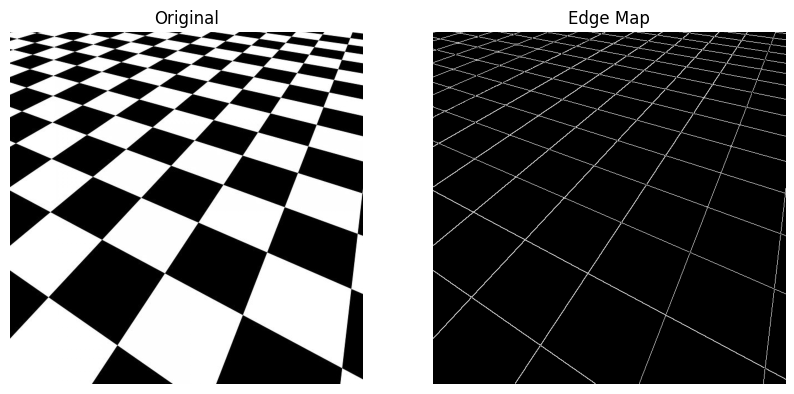

In [398]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img3 = cv2.imread("./checkerboard.png", cv2.IMREAD_GRAYSCALE)
print(img3.shape)

img_edge3 = cv2.Canny(img3, threshold1=100, threshold2=200, apertureSize=3)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img3, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_edge3, cmap='gray')
plt.title('Edge Map')
plt.axis('off')

Peak 173: (1.2321326387379168, 549.4000000000001), Votes: 63.0
Peak 174: (1.5701680082641785, 625.8), Votes: 76.0
Peak 175: (1.5714246453256147, 626.2), Votes: 76.0
Peak 176: (1.198203438079147, 517.8), Votes: 87.0
Peak 177: (1.1592476891746335, 480.20000000000005), Votes: 109.0
Peak 178: (1.1127521179015045, 433.8), Votes: 133.0
Peak 179: (3.2565749447111796, 594.6), Votes: 141.0
Peak 180: (2.1796369830605986, 167.8), Votes: 143.0
Peak 181: (2.1808936201220344, 168.2), Votes: 143.0
Peak 182: (1.0511769018911448, 373.0), Votes: 161.0
Peak 183: (1.0511769018911448, 373.40000000000003), Votes: 161.0
Peak 184: (0.9757786782049898, 295.4), Votes: 193.0
Peak 185: (0.9745220411435538, 294.6), Votes: 193.0
Peak 186: (1.7548936562952584, 649.0), Votes: 207.0
Peak 187: (1.7724865751553613, 633.0), Votes: 232.0
Peak 188: (0.8790176244744241, 193.40000000000003), Votes: 238.0
Peak 189: (1.790079494015464, 613.0), Votes: 249.0
Peak 190: (1.8126989611213107, 589.0), Votes: 252.0
Peak 191: (1.840344

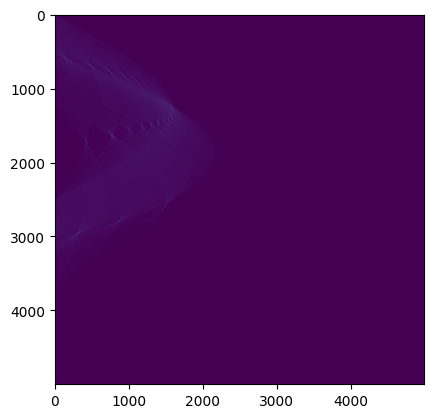

In [399]:
lines3_polar = hough_polar(img_edge3, num_lines=200, non_max_suppression=True, suppression_window_halfsize=20)

r :549.4000000000001, theta: 1.2321326387379168
a :-0.35223406316843014, b: 57.514513572660235
r :625.8, theta: 1.5701680082641785
a :-0.000628318613401576, b: 14.199876472011056
r :626.2, theta: 1.5714246453256147
a :0.0006283186134014534, b: 13.799876393054092
r :517.8, theta: 1.198203438079147
a :-0.39084912856584253, b: 84.0546934253988
r :480.20000000000005, theta: 1.1592476891746335
a :-0.43647362808376905, b: 116.05157550933268
r :433.8, theta: 1.1127521179015045
a :-0.49301524594872814, b: 156.34431383797926
r :594.6, theta: 3.2565749447111796
a :-8.658630171209591, b: 5822.64344708523
r :167.8, theta: 2.1796369830605986
a :0.6971945899158319, b: 435.44358937574555
r :168.2, theta: 2.1808936201220344
a :0.6990636920349689, b: 434.77600685236285
r :373.0, theta: 1.0511769018911448
a :-0.5720566024106748, b: 210.2805656898454
r :373.40000000000003, theta: 1.0511769018911448
a :-0.5720566024106748, b: 209.81974055921785
r :295.4, theta: 0.9757786782049898
a :-0.6768472881841884, b

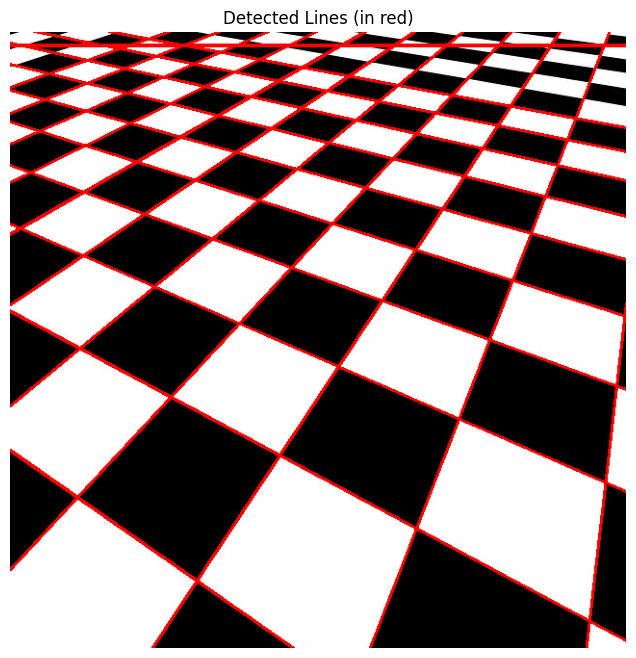

In [460]:
# first convert the gray scale image to color
color_img3 = cv2.cvtColor(img3, cv2.COLOR_GRAY2RGB) 

plt.figure(figsize=(8,8))
plt.imshow(color_img3, origin='lower') 
plt.title("Detected Lines (in red)")
plt.axis('off')

# display the lines overlayed on the image
for line in lines3_polar:
    theta, r = line
    a = -1.0/np.tan(theta)
    b = color_img3.shape[0] - (r / np.sin(theta))
    print(f"r :{r}, theta: {theta}")
    print(f"a :{a}, b: {b}")
    x1 = 0
    x2 = color_img3.shape[1]
    y1 = int(a*x1 + b)
    y2 = int(a*x2 + b)

    # draw the line in red
    cv2.line(color_img3,(x1,y1),(x2,y2),(255,0,0),2)

plt.imshow(color_img3) 
plt.title("Detected Lines (in red)")
plt.axis('off')
plt.show()

(640, 640)


(-0.5, 799.5, 533.5, -0.5)

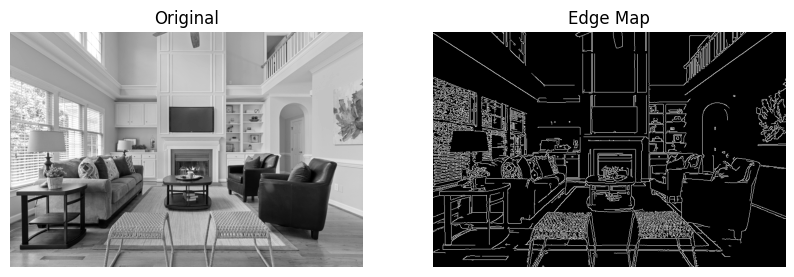

In [440]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img4 = cv2.imread("./canny_im.png", cv2.IMREAD_GRAYSCALE)
print(img3.shape)

img_edge4 = cv2.Canny(img4, threshold1=100, threshold2=200, apertureSize=3)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img4, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_edge4, cmap='gray')
plt.title('Edge Map')
plt.axis('off')

Peak 0: (4.024380189248525, 116.60000000000001), Votes: 58.0
Peak 1: (2.2952475927127027, 398.20000000000005), Votes: 58.0
Peak 2: (1.6769821584862314, 405.0), Votes: 59.0
Peak 3: (2.0979555740672637, 231.0), Votes: 59.0
Peak 4: (3.142220972120511, 397.8), Votes: 59.0
Peak 5: (1.790079494015464, 294.20000000000005), Votes: 59.0
Peak 6: (3.140964335059075, 398.20000000000005), Votes: 59.0
Peak 7: (2.97634488001097, 78.60000000000001), Votes: 59.0
Peak 8: (1.7285042780051043, 120.2), Votes: 59.0
Peak 9: (2.0979555740672637, 230.2), Votes: 59.0
Peak 10: (1.3464866113285852, 35.0), Votes: 59.0
Peak 11: (1.2183096310621218, 25.8), Votes: 59.0
Peak 12: (2.5591413756142454, 309.40000000000003), Votes: 59.0
Peak 13: (1.440734390936279, 1.4000000000000001), Votes: 60.0
Peak 14: (1.4055485532160734, 111.4), Votes: 60.0
Peak 15: (3.1472475203662547, 3.8), Votes: 60.0
Peak 16: (2.148221056524701, 242.2), Votes: 60.0
Peak 17: (3.0404333701442017, 51.8), Votes: 60.0
Peak 18: (0.9682388558363743, 0.6

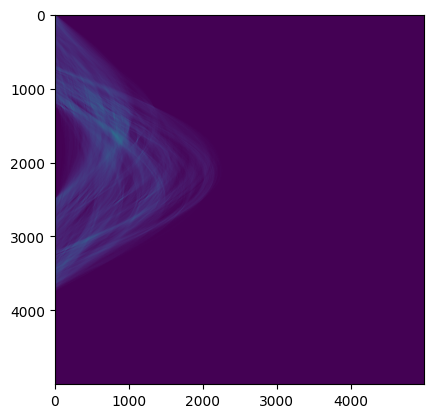

In [441]:
lines4_polar = hough_polar(img_edge4, num_lines=200, non_max_suppression=True, suppression_window_halfsize=20)

r :159.0, theta: 3.142220972120511
a :-1591.549221479397, b: 253590.37616654893
r :159.0, theta: 3.140964335059075
a :1591.5492214787764, b: -252522.3761664503
r :127.0, theta: 3.142220972120511
a :-1591.549221479397, b: 202660.7910261114
r :395.40000000000003, theta: 1.5714246453256147
a :0.0006283186134014534, b: 138.59992195115552
r :394.6, theta: 1.5701680082641785
a :-0.000628318613401576, b: 139.39992210906922
r :393.8, theta: 1.5676547341413067
a :-0.003141602989056244, b: 140.19805666690178
r :521.8, theta: 3.142220972120511
a :-1591.549221479397, b: 831004.5476962592
r :522.2, theta: 3.140964335059075
a :1591.5492214787764, b: -830573.1675101909
r :345.8, theta: 1.5701680082641785
a :-0.000628318613401576, b: 188.19993174180473
r :64.2, theta: 1.5714246453256147
a :0.0006283186134014534, b: 469.79998732742587
r :266.20000000000005, theta: 1.5714246453256147
a :0.0006283186134014534, b: 267.7999474542175
r :265.8, theta: 1.5701680082641785
a :-0.000628318613401576, b: 268.19994

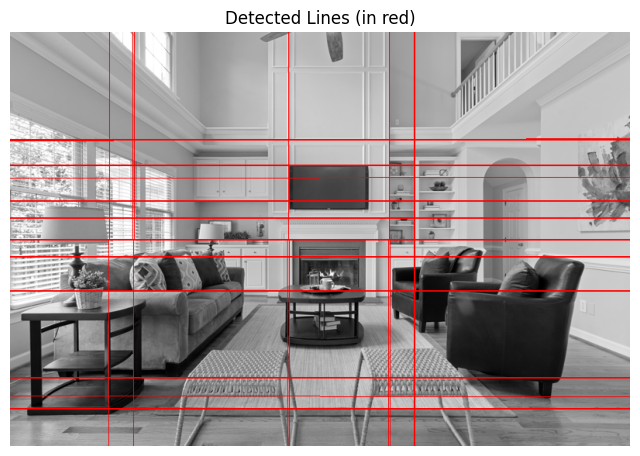

In [461]:
# first convert the gray scale image to color
color_img4 = cv2.cvtColor(img4, cv2.COLOR_GRAY2RGB) 

plt.figure(figsize=(8,8))


# display the lines overlayed on the image
for line in lines4_polar[170:]:
    theta, r = line
    a = -1.0/np.tan(theta)
    b = color_img4.shape[0] - (r / np.sin(theta))
    print(f"r :{r}, theta: {theta}")
    print(f"a :{a}, b: {b}")
    x1 = 0
    x2 = color_img4.shape[1]
    y1 = int(a*x1 + b)
    y2 = int(a*x2 + b)

    # draw the line in red
    cv2.line(color_img4,(x1,y1),(x2,y2),(255,0,0),1)

plt.imshow(color_img4) 
plt.title("Detected Lines (in red)")
plt.axis('off')
plt.show()